# Camera Portrait Modes

- **Mode 1: Shallow Focus**
- **Mode 2: Change Background**

In [1]:
import os
from IPython.display import Image

import tarfile
import urllib

import numpy as np
import tensorflow as tf
import cv2

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [3]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/aiffel_projects/exploration/E8_human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')

if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/aiffel_projects/exploration/E8_human_segmentation/models
model loaded successfully!


In [5]:
img_path = os.getenv('HOME')+'/aiffel/aiffel_projects/exploration/E8_human_segmentation/images'

In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [52]:
class Portrait():
    def __init__(self, img, label):
        current_path = os.path.join(img_path, img)
        self.current_img = cv2.imread(current_path)

        self.current_resized, self.current_seg_map = MODEL.run(self.current_img)

        self.category = LABEL_NAMES.index(label)
        
    
    def get_segment(self):
        current_show = self.current_resized.copy()

        self.current_seg_map = np.where(self.current_seg_map == self.category, self.category, 0)
        current_mask = self.current_seg_map * (255 / self.current_seg_map.max())

        current_mask = current_mask.astype(np.uint8)

        current_mask_up = cv2.resize(current_mask, self.current_img.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
        _, current_mask_up = cv2.threshold(current_mask_up, 128, 255, cv2.THRESH_BINARY)
        
        return self.current_img, current_mask_up
    
    
    # Function for shallow focused image
    def get_blurred(self):
        current_img, current_mask_up = self.get_segment()
        
        current_blur = cv2.blur(current_img, (20, 20))
        current_mask_color = cv2.cvtColor(current_mask_up, cv2.COLOR_GRAY2BGR)
        current_bg_mask = cv2.bitwise_not(current_mask_color)
        current_bg_blur = cv2.bitwise_and(current_blur, current_bg_mask)
        
        current_concat = np.where(current_mask_color==255, current_img, current_bg_blur)
        
        plt.figure(figsize=(15, 15))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(current_img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(current_concat, cv2.COLOR_BGR2RGB))
        plt.title('Blurred Image')
        
        plt.show()
        
    
    # Function for new background image
    def get_new_back(self, back_img):
        current_img, current_mask_up = self.get_segment()
        
        back_path = os.path.join(img_path, back_img)
        
        back_org = cv2.imread(back_path)
        back_resized = cv2.resize(back_org, (current_img.shape[1], current_img.shape[0]))
        
        current_mask_color = cv2.cvtColor(current_mask_up, cv2.COLOR_GRAY2BGR)
        current_concat = np.where(current_mask_color==255, current_img, back_resized)
        
        plt.figure(figsize=(15, 15))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(current_img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(current_concat, cv2.COLOR_BGR2RGB))
        plt.title('New Background')
        
        plt.show()

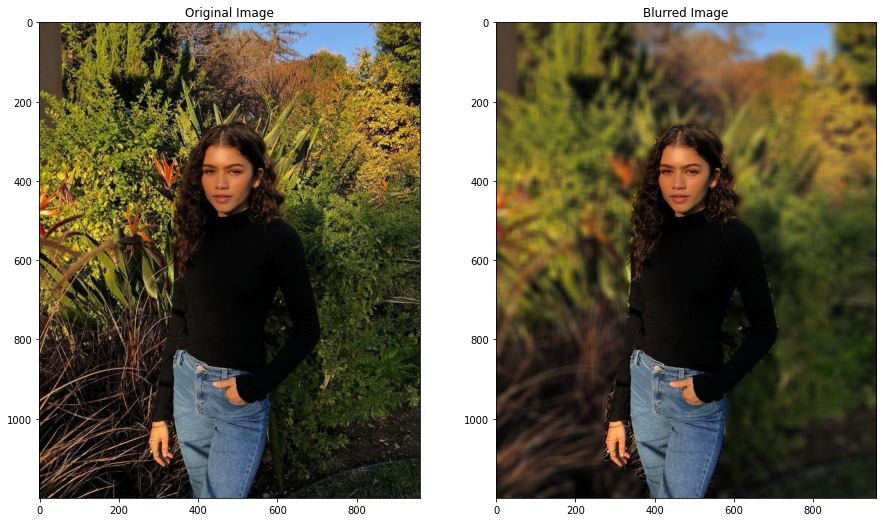

In [53]:
zen1 = Portrait('1.jpg', 'person')

zen1.get_blurred()

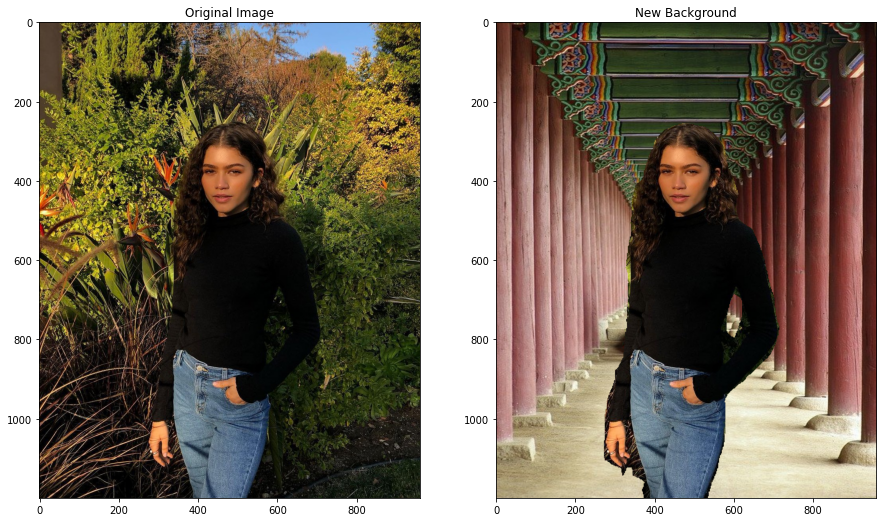

In [54]:
zen1.get_new_back('aisle.jpg')

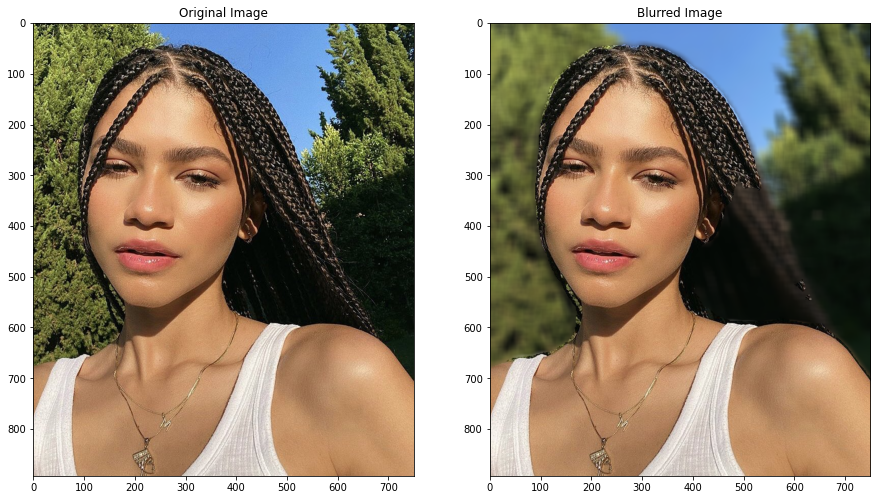

In [55]:
zen2 = Portrait('3.jpg', 'person')

zen2.get_blurred()

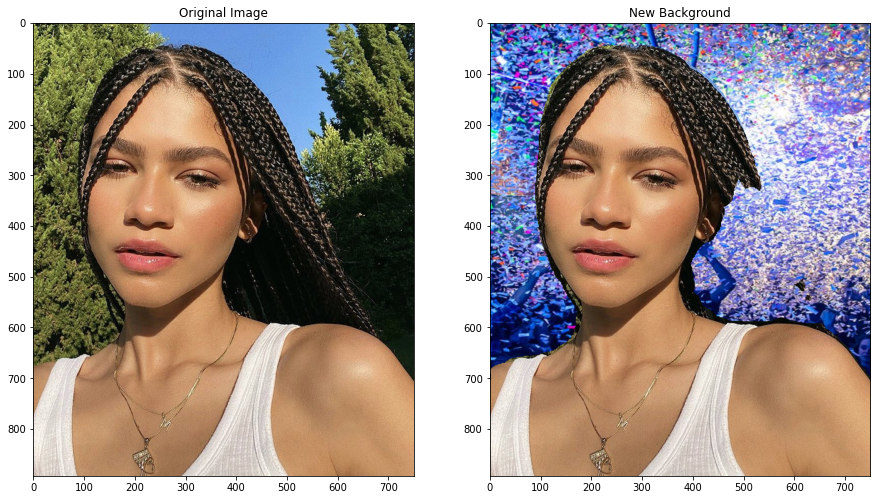

In [56]:
zen2.get_new_back('party.jpg')

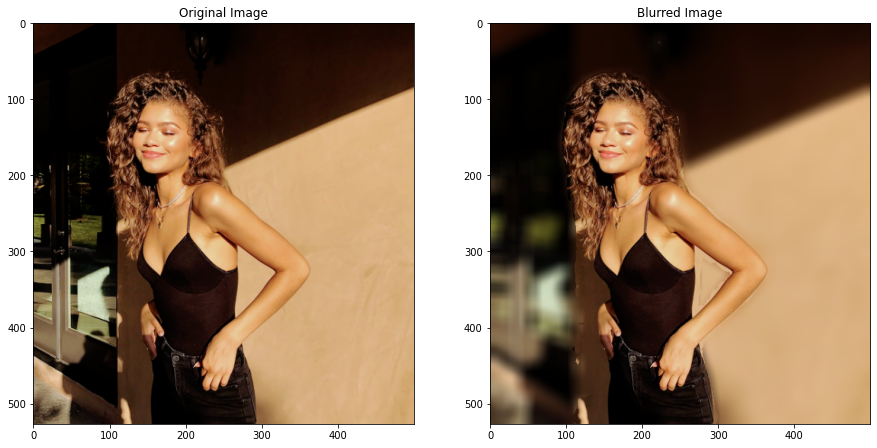

In [57]:
zen3 = Portrait('6.png', 'person')

zen3.get_blurred()

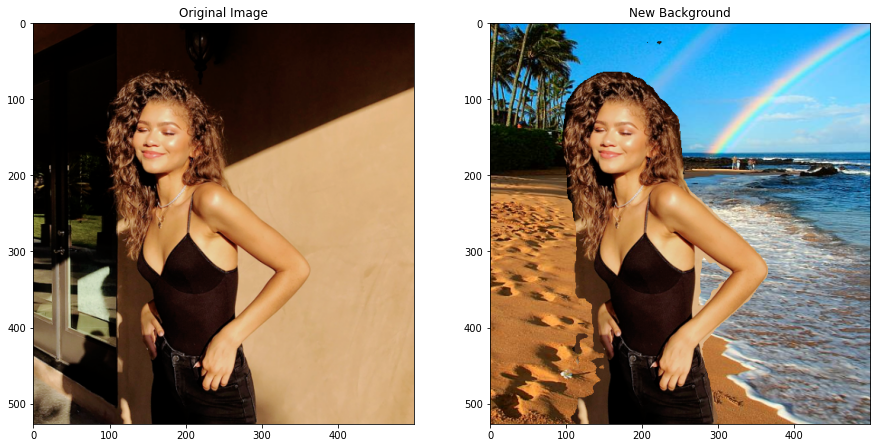

In [58]:
zen3.get_new_back('hawaii.jpg')

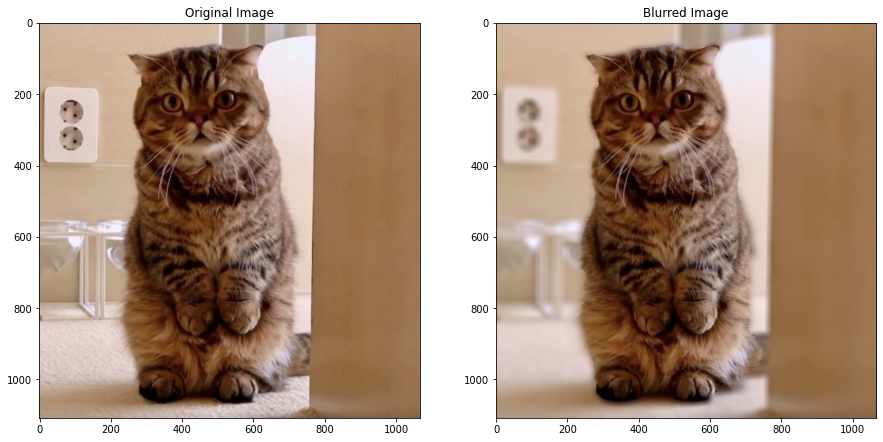

In [59]:
ruru = Portrait('ruru.jpeg', 'cat')

ruru.get_blurred()

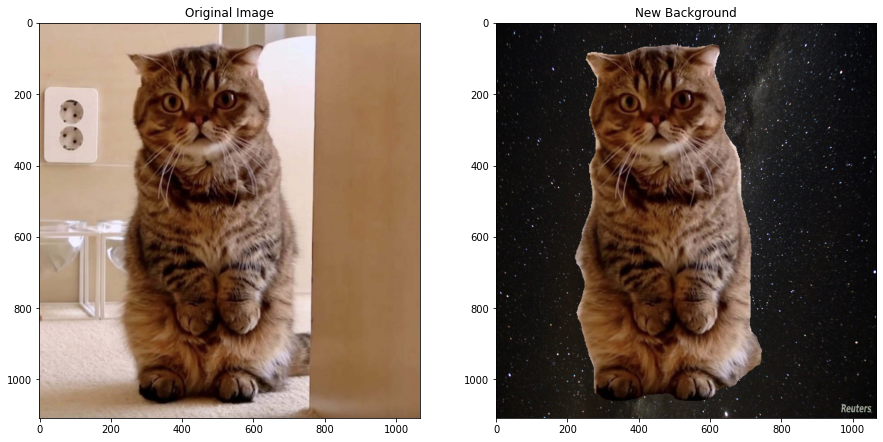

In [60]:
ruru.get_new_back('galaxy.jpg')

<hr>

<br>

## Problems

- 배경의 일부가 person 영역에 포함됨
- 옷의 일부가 person 영역에 포함됨
- 머리카락이 배경으로 분류됨
- 고양이 털과 같이 경계가 분명하지 않을 경우, 경계면 처리가 어색함

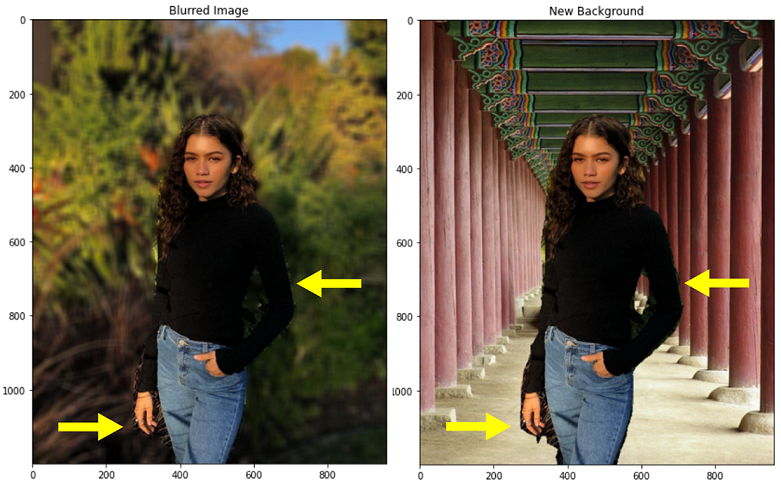

In [9]:
Image(img_path + '/comment1.png')

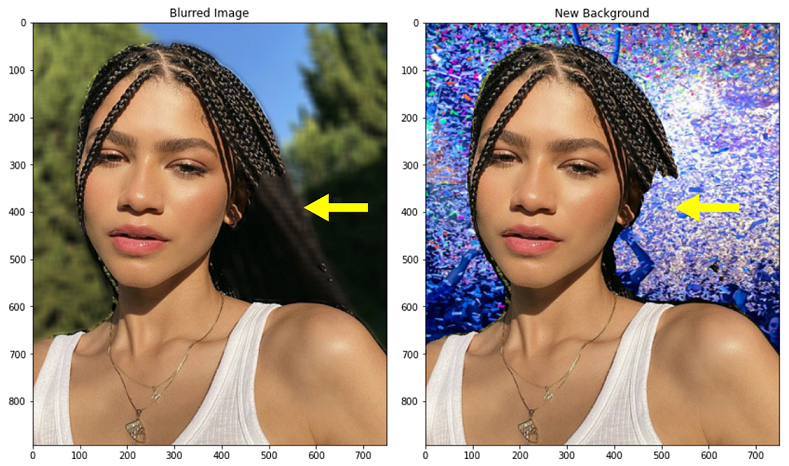

In [10]:
Image(img_path + '/comment2.png')

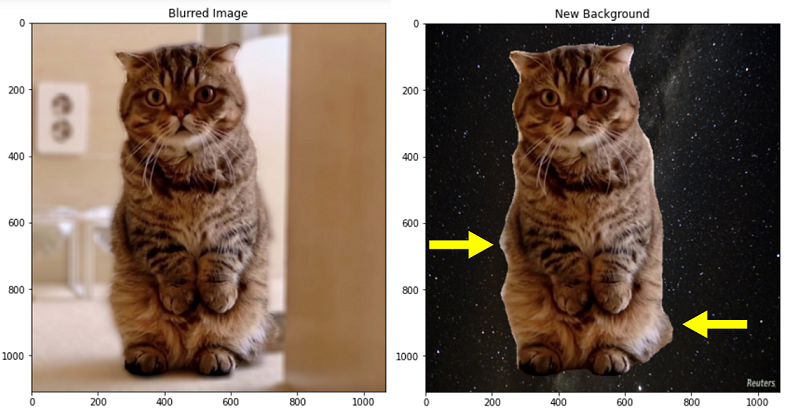

In [11]:
Image(img_path + '/comment3.png')